In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax, default_mlp_architecture
from utils.common import test40_mlp_architecture, testRELU_mlp_architecture, two_layer_mlp_architecture
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.mlp import MLP
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V1 model regressionT
                  (False, "run_20170908_18_26_21_metaV1_13ep_50ops_lr1e05"), # 50ops
                  (False, "run_20170911_12_11_16_metaV1_12ep_100ops_lr1e05"),
                  # Graves ACT
                  (True, "run_20170908_13_17_26_act_gravesV1_10ep_tau0.003_lr6e04"),
                  (True, "run_20170910_20_06_36_act_gravesV1_12ep_tau0.0025_lr6e04"),
                  (True, "run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04"),
                  (False, "run_20170911_07_47_26_act_gravesV1_10ep_tau0.0022_lr6e04"),
                  (True, "run_20170911_15_14_14_act_gravesV1_10ep_tau0.0022_lr6e04"), 
                  (False, "run_20170911_14_53_59_act_gravesV1_10ep_tau0.002_lr6e04")] 



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class


INFO - created local logger for experiment with model act_gravesV1_mlp_tau0.003
INFO - INFO - loaded existing model from file logs/run_20170908_13_17_26_act_gravesV1_10ep_tau0.003_lr6e04/act_gravesV1_mlp_tau0.003.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']


0 Loading model act_gravesV1_mlp_tau0.003 (q-prob 0.60) / run_20170908_13_17_26_act_gravesV1_10ep_tau0.003_lr6e04


INFO - created local logger for experiment with model act_gravesV1_mlp_tau0.0025
INFO - INFO - loaded existing model from file logs/run_20170910_20_06_36_act_gravesV1_12ep_tau0.0025_lr6e04/act_gravesV1_mlp_tau0.0025.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']


1 Loading model act_gravesV1_mlp_tau0.0025 (q-prob 0.90) / run_20170910_20_06_36_act_gravesV1_12ep_tau0.0025_lr6e04


INFO - created local logger for experiment with model act_gravesV1_mlp_tau0.0023
INFO - INFO - loaded existing model from file logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/act_gravesV1_mlp_tau0.0023.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']


2 Loading model act_gravesV1_mlp_tau0.0023 (q-prob 0.90) / run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04


INFO - created local logger for experiment with model act_gravesV1_mlp_tau0.0022
INFO - INFO - loaded existing model from file logs/run_20170911_15_14_14_act_gravesV1_10ep_tau0.0022_lr6e04/act_gravesV1_mlp_tau0.0022.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']


3 Loading model act_gravesV1_mlp_tau0.0022 (q-prob 0.90) / run_20170911_15_14_14_act_gravesV1_10ep_tau0.0022_lr6e04


In [8]:
del new_experiments
new_experiments = []
unrolled_steps=60

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_50_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170908_13_17_26_act_gravesV1_10ep_tau0.003_lr6e04 / path run_20170908_13_17_26_act_gravesV1_10ep_tau0.003_lr6e04/exp_eval_stats_50_60steps.dll
Loading experiment run_20170910_20_06_36_act_gravesV1_12ep_tau0.0025_lr6e04 / path run_20170910_20_06_36_act_gravesV1_12ep_tau0.0025_lr6e04/exp_eval_stats_50_60steps.dll
Loading experiment run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04 / path run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/exp_eval_stats_50_60steps.dll
Loading experiment run_20170911_15_14_14_act_gravesV1_10ep_tau0.0022_lr6e04 / path run_20170911_15_14_14_act_gravesV1_10ep_tau0.0022_lr6e04/exp_eval_stats_50_60steps.dll
Ready


In [5]:
with open("data/test_mlp_50.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


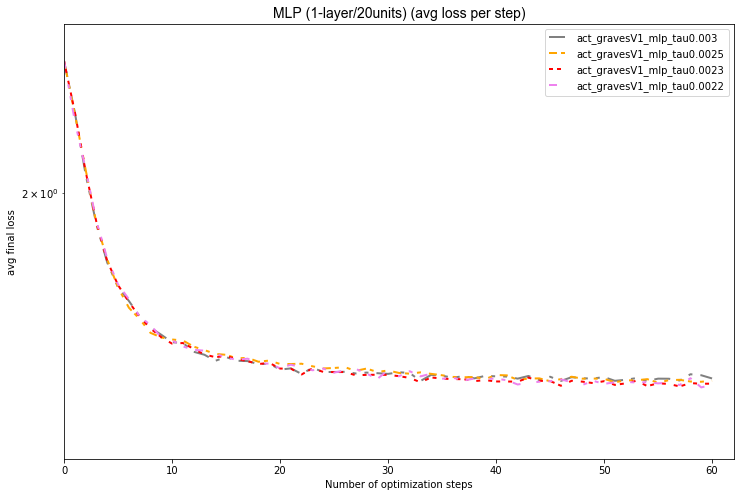

In [9]:
# some_experiments=[new_experiments[0], new_experiments[1], new_experiments[2]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="mlp_35unroll_metaV1_act_graves_0_35", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=60,
                                              sort_exper="MLP (1-layer/20units)",
                                              log_scale=True,
                                              y_lim=[1.5, 2.4],
                                              with_stddev=False,
                                              runID=None)

In [ ]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [7]:
exp_idx = 2
model = models[exp_idx]

max_steps = 35
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].meta_logger = logger

epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} ".format(model.name))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_50_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 50 test functions


Validating model act_gravesV1_mlp_tau0.0023 


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 2.305  2.176  2.046  1.941  1.863  1.801  1.768  1.734  1.723  1.707
  1.698  1.687  1.684  1.676  1.674  1.665  1.666  1.666  1.656  1.658
  1.657  1.655  1.653  1.651  1.648  1.649  1.649  1.643  1.639  1.637
  1.644  1.638  1.64   1.635  1.63   1.631]
INFO - ! - Validation last step 19 - !
INFO - Epoch: 400 - evaluation - halting step distribution
INFO - [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 50]
INFO - Epoch: 400 - evaluation - Average number of optimization steps 19.000 stddev 0.000 median 19 sum-steps 950
INFO - Epoch: 400 - End test evaluation (elapsed time 30.99 sec) avg act loss/kl-term/penalty 1.717/0.0438/0.0000
INFO - Epoch: 400 - End test evaluation - Avg accuracy 83.594
INFO - Epoch: 400 - Successfully saved model to logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/act_gravesV1_mlp_tau0.0023_eval_run400.pkl
INFO - Epoch: 400 - Saving experimental details to logs/run_20170911_18_

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:
exp_idx = 0
max_steps = 60
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_50_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


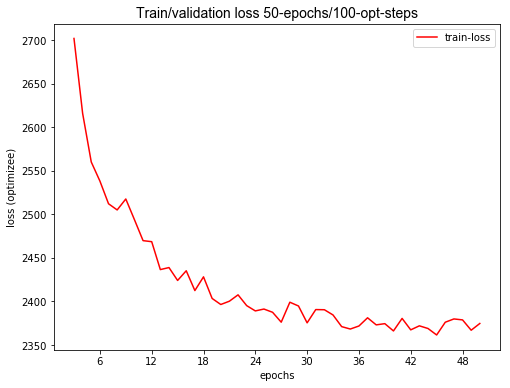

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


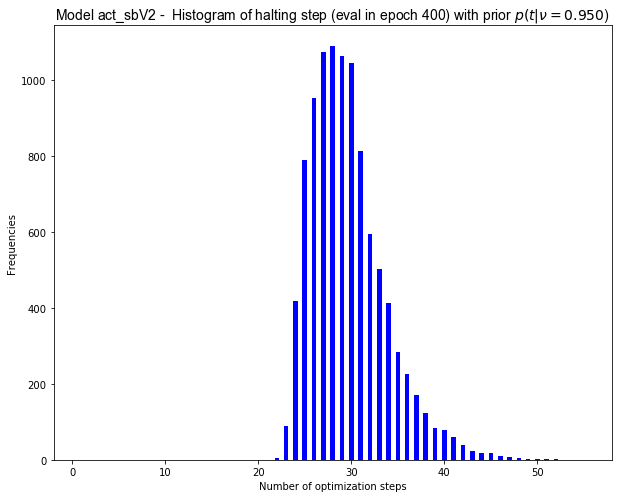

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

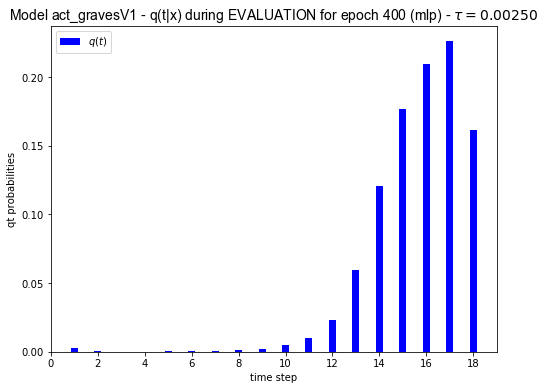

In [7]:
plot_actsb_qts(new_experiments[5], data_set="eval", fig_name="qt_test", height=8, width=6, save=False, show=True)

In [10]:
print(np.mean(new_experiments[5].val_stats["loss_funcs"][400][:,25]) ,
      np.std(new_experiments[5].val_stats["loss_funcs"][400][:,25]))

(1.6524886, 0.027550859)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [15]:
# two_layer_mlp_architecture, default_mlp_architecture

test_funcs = []
num_of_funcs = 50
for _ in np.arange(num_of_funcs):
    test_funcs.append(MLP(two_layer_mlp_architecture))
with open("data/test_2layer_mlp_" + str(num_of_funcs) + ".dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [13]:
new_experiments[4].val_stats["step_acc"][400]

87.109375

In [4]:
experiments[2].generate_figures()

INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/loss_train_act_gravesV1_10ep_tau0.0023.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/loss_optimizer_train_act_gravesV1_10ep_tau0.0023.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/loss_eval_act_gravesV1_10ep_tau0.0023.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/loss_optimizer_eval_act_gravesV1_10ep_tau0.0023.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/train_step_loss_map_act_gravesV1_10ep_tau0.0023.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/T_dist_train.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10ep_tau0.0023_lr6e04/gradient_statistics.png
INFO - Successfully saved fig logs/run_20170911_18_08_16_act_gravesV1_10e